In [1]:
from keras.layers import Input, Dense,Dropout, Flatten,Lambda
from keras.models import Model,Sequential
from sklearn.model_selection import train_test_split as tts
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from keras.utils import np_utils,plot_model
from keras.layers.convolutional import Convolution2D,MaxPooling2D,Conv2D
from keras import backend as K
from keras.losses import categorical_hinge,categorical_crossentropy
import tensorflow as tf

Using TensorFlow backend.
/home/slcf/.pyenv/versions/3.6.2/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from keras.datasets import fashion_mnist as mnist
import numpy as np
(x_train,y_train),(x_test,y_test) = mnist.load_data()

In [3]:
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0
## Make the input image flat
n_features = np.prod(x_train.shape[1:])
xtrain = x_train.reshape((len(x_train),n_features))
xtest = x_test.reshape((len(x_test),n_features))

In [4]:
### Construct Classifier
X_train = xtrain.reshape(xtrain.shape[0],28,28,1)
Y_train = np_utils.to_categorical(y_train)
X_test = xtest.reshape(xtest.shape[0],28,28,1)
Y_test = np_utils.to_categorical(y_test)
#Y_test = y_test
## in this example, we used sparse cross entropy loss!
num_classes = 10
Xtr, Xval, Ytr, Yval = tts(X_train,Y_train,test_size = 0.3)
#Xtr, Xval, Ytr, Yval = tts(Xtr,Ytr,test_size = 0.3)

In [5]:
import sys
sys.path.append('../')
from mnist_clf import *
from mnist_dae import *

# Training Classifier

In [6]:
mnist_cnn = Mnist_CNN(X_train,Y_train)

In [7]:
#mnist_cnn.train("../logs/fashion_mnist_CNN_clf.ckpt")
mnist_cnn.restore('../logs/fashion_mnist_CNN_clf.ckpt')

INFO:tensorflow:Restoring parameters from ../logs/fashion_mnist_CNN_clf.ckpt
Success!


In [8]:
mnist_cnn.accuracy_score(X_test,Y_test)

0.88510001

In [9]:
print(Y_test.shape)
X_test = xtest.reshape(xtest.shape[0],28,28,1)
Y_test = np_utils.to_categorical(y_test)
print(X_test.shape)

(10000, 10)
(10000, 28, 28, 1)


In [10]:
_,xtest_n = corrupt(X_test,scale =0.3,noise_type = 'peppSalt')
test_acc = mnist_cnn.sess.run(mnist_cnn.accuracy,feed_dict = {mnist_cnn.eval_imgs:xtest_n,mnist_cnn.labels_eval:Y_test})
print(test_acc)

0.2526


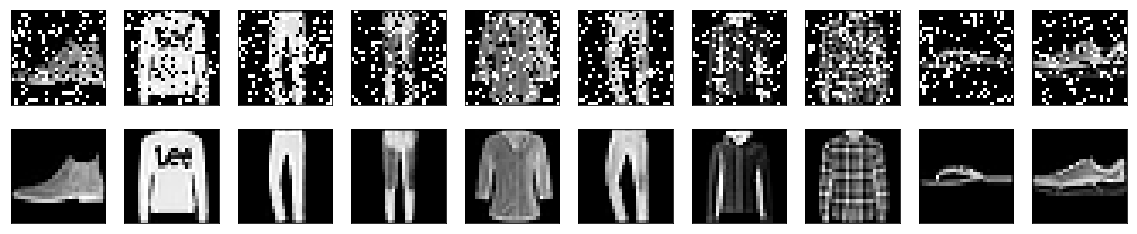

In [11]:
n=10
plt.figure(figsize = (20,4))
for i in range(n):
    # Display Original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(xtest_n[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax .get_yaxis().set_visible(False)
    
    # Display Reconstruction
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(X_test[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Adversarial Attacks (PGD)

In [25]:
mnist_cnn.targeted_attack(X_test,Y_test,file_name = 'minstF_adv')

[0/10000] processed
[100/10000] processed
[200/10000] processed
[300/10000] processed
[400/10000] processed
[500/10000] processed
[600/10000] processed
[700/10000] processed
[800/10000] processed
[900/10000] processed
[1000/10000] processed
[1100/10000] processed
[1200/10000] processed
[1300/10000] processed
[1400/10000] processed
[1500/10000] processed
[1600/10000] processed
[1700/10000] processed
[1800/10000] processed
[1900/10000] processed
[2000/10000] processed
[2100/10000] processed
[2200/10000] processed
[2300/10000] processed
[2400/10000] processed
[2500/10000] processed
[2600/10000] processed
[2700/10000] processed
[2800/10000] processed
[2900/10000] processed
[3000/10000] processed
[3100/10000] processed
[3200/10000] processed
[3300/10000] processed
[3400/10000] processed
[3500/10000] processed
[3600/10000] processed
[3700/10000] processed
[3800/10000] processed
[3900/10000] processed
[4000/10000] processed
[4100/10000] processed
[4200/10000] processed
[4300/10000] processed


NameError: name 'advX' is not defined

In [26]:
print(mnist_cnn.accuracy_score(mnist_cnn.advX,Y_test))
print(mnist_cnn.accuracy_score(mnist_cnn.advX,mnist_cnn.advY))

0.232
0.7118


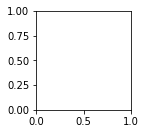

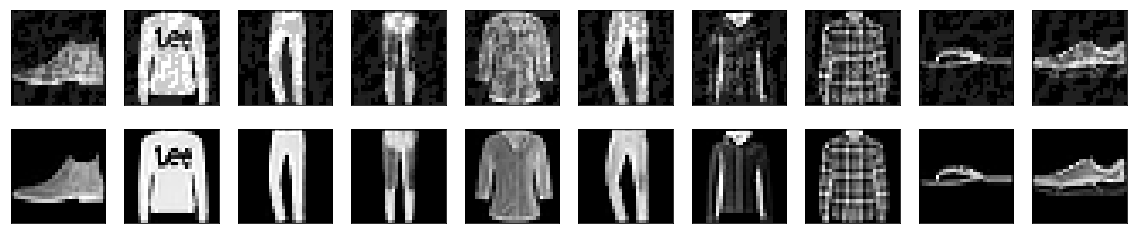

In [27]:
n=10
plt.figure(figsize = (20,4))
for i in range(n):
    # Display Original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(mnist_cnn.advX[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax .get_yaxis().set_visible(False)
    
    # Display Reconstruction
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(X_test[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Training Denoising Autoencoder

In [12]:
encoder, decoder, autoencoder = mnist_dae()

In [13]:
autoencoder.compile(optimizer = 'adadelta',loss='binary_crossentropy')

In [14]:
## Generate noised images
noise_scale = 0.3
xtrain_o,xtrain_n = corrupt(xtrain,scale = noise_scale)

In [15]:
xtrain_t = np.concatenate([xtrain_o,xtrain_n],axis =1)
print(xtrain_t.shape)
dmm = np.ones(shape = (len(xtrain_t),))
xtr,xval,_,_ = tts(xtrain_t,dmm,test_size = 0.3)
xtr_o = xtr[:,:n_features]
xtr_n = xtr[:,n_features:]
xval_o = xval[:,:n_features]
xval_n = xval[:,n_features:]

(60000, 1568)


In [16]:
## Training the model
print("noise_scale: ",noise_scale)
autoencoder.fit(xtr_n,xtr_o,
               epochs = 50,
               batch_size = 128,
               shuffle=True,
               validation_data=(xval_n,xval_o),
               callbacks = [TensorBoard(log_dir = '../logs/mnist_denseDAE', histogram_freq=0,write_graph=False)]
                )

noise_scale:  0.3
Train on 42000 samples, validate on 18000 samples
Epoch 1/50
42000/42000 [==============================] - 4s 89us/step - loss: 0.3986 - val_loss: 0.3369
Epoch 2/50
42000/42000 [==============================] - 4s 88us/step - loss: 0.3277 - val_loss: 0.3261
Epoch 3/50
42000/42000 [==============================] - 4s 88us/step - loss: 0.3163 - val_loss: 0.3135
Epoch 4/50
42000/42000 [==============================] - 4s 88us/step - loss: 0.3102 - val_loss: 0.3082
Epoch 5/50
42000/42000 [==============================] - 4s 89us/step - loss: 0.3063 - val_loss: 0.3047
Epoch 6/50
42000/42000 [==============================] - 4s 88us/step - loss: 0.3033 - val_loss: 0.3036
Epoch 7/50
42000/42000 [==============================] - 4s 88us/step - loss: 0.3007 - val_loss: 0.2998
Epoch 8/50
42000/42000 [==============================] - 4s 87us/step - loss: 0.2985 - val_loss: 0.2978
Epoch 9/50
42000/42000 [==============================] - 3s 82us/step - loss: 0.2964 - val_

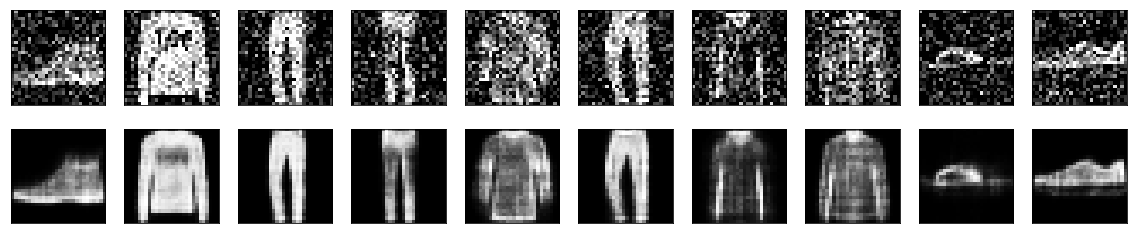

In [17]:
xtest_o,xtest_n = corrupt(xtest,scale =0.3)
decoded_imgs = autoencoder.predict(xtest_n)

n=10
plt.figure(figsize = (20,4))
for i in range(n):
    # Display Original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(xtest_n[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax .get_yaxis().set_visible(False)
    
    # Display Reconstruction
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [20]:
print(xtest_n.shape)

(10000, 784)


In [21]:
mnist_cnn.accuracy_score(xtest_n.reshape(-1,28,28,1),Y_test)

0.58859998

In [22]:
mnist_cnn.accuracy_score(decoded_imgs.reshape(-1,28,28,1),Y_test)

0.80269998

In [28]:
print(mnist_cnn.advX.shape)

(10000, 28, 28, 1)


In [29]:
decoded_advX = autoencoder.predict(mnist_cnn.advX.reshape(-1,784))

In [31]:
mnist_cnn.accuracy_score(decoded_advX.reshape(-1,28,28,1),Y_test)

0.76169997

In [35]:
mnist_cnn.accuracy_score(decoded_advX.reshape(-1,28,28,1),mnist_cnn.advY)

0.093000002

# Applying DS to noised data